# Tensorflow Setup and Utility Functions

This notebook provides essential functions for setting up a Tensorflow Environment, loading and preprocessing image datasets, and visualizing the data. It's designed to be flexible and adaptable to various directory structures and image formats.

## Imports

- **tensorflow (tf)**: The main library for machine learning operations.
- **numpy (np)**: A library for numerical operations on large, multi-dimensional arrays and matrices.
- **matplotlib.pyplot (plt)**: A library for creating visualizations.
- **seaborn (sns)**: A library for creating more attractive visualizations.
- **pandas (pd)**: A library for data manipulation and analysis.
- **time**: A library for working with time and measuring performance.
- **pathlib.Path**: Provides an object-oriented interface for working with filesystem paths.
- **typing**: A library for type hints and annotations.
- **datetime**: A library for working with dates and times.
- **tqdm**: A library for creating interactive progress bars.
- **sklearn**: A library for machine learning operations.

## GPU Functions

The following functions are used to set up the Tensorflow environment and check for the presence of a GPU.


In [37]:
import warnings
import os
import logging

In [38]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.FATAL)
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

warnings.filterwarnings("ignore")

In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from tqdm import tqdm
from pathlib import Path
from typing import Tuple, List, Dict, Optional
from datetime import datetime
from sklearn.manifold import TSNE

### Tensorflow Auxiliary Functinons and Configuration


In [40]:
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.17.0


In [41]:
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")

Built with CUDA: True


### Setting Up GPU Configuration


In [42]:
from dataclasses import dataclass, field

In [43]:
@dataclass
class MemoryConfig:
    max_memory_gb: float = 8.0
    batch_size: int = 32
    prefetch_buffer: int = 2
    cache_dataset: bool = True
    mixed_precision: bool = True
    memory_growth: bool = True

In [44]:
def setup_gpu() -> Tuple[tf.distribute.Strategy, int]:
    """
    Set up a GPU strategy for tensorflow.

    This function does the following
    1. Detects available GPUs.
    2. Sets up an appropriate strategy for the available GPUs.
    3. Returns the strategy and number of GPUs available.

    This function handles three cases:
    - No GPUs: returns a default strategy using CPU.
    - Single GPU: returns a MirroredStrategy with a single device.
    - Multiple GPUs: returns a MirroredStrategy with all available devices.

    Returns:
      tuple: (tf.distribute.Strategy, int) where the first element is the strategy and the second element is the number of GPUs available.
    """

    gpus = tf.config.list_physical_devices("GPU")
    num_gpus = len(gpus)

    if num_gpus == 0:
        print(f"No GPUs detected. Running on CPU.")
        print(f"Devices: {tf.config.list_physical_devices('CPU')}")
        print(f"Logical devices: {tf.config.list_logical_devices('CPU')}")

        return tf.distribute.get_strategy(), 0

    elif num_gpus == 1:
        print(f"1 GPU detected: {gpus[0].name}")
        print(tf.config.experimental.get_device_details(gpus[0]))

        return tf.distribute.OneDeviceStrategy(device="/gpu:0"), 1

    else:
        print(f"{num_gpus} GPUs detected: {[gpu.name for gpu in gpus]}")
        print([tf.config.experimental.get_device_details(gpu) for gpu in gpus])

        return tf.distribute.MirroredStrategy(), num_gpus

In [45]:
strategy, num_gpus = setup_gpu()

1 GPU detected: /physical_device:GPU:0
{'compute_capability': (8, 6), 'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU'}


I0000 00:00:1730825001.911307   35954 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [46]:
def setup_tensorboard():
    """
    Setup a TensorBoard for visualization. To view the TensorBoard, run the following command in the terminal:
    tensorboard --logdir logs/scalars
    """

    logdir = "logs/scalars" + datetime.now().strftime("%Y%m%d-%H%M%S")
    file_writer = tf.summary.create_file_writer(str(logdir + "/metrics"))
    file_writer.set_as_default()

    print(f"TensorBoard logs will be saved to: {logdir}")

In [47]:
def benchmark_data_pipeline(dataset: tf.data.Dataset):
    """
    Benchmark the data pipeline to ensure efficient data loading.

    Args:
      dataset (tf.data.Dataset): Dataset to benchmark.
    """

    start_time = time.time()
    for _ in tqdm(dataset, desc="Benchmarking data pipeline"):
        pass

    end_time = time.time()
    print(f"Data pipeline benchmark: {end_time - start_time:.2f} seconds")

### Auxiliary Functions


In [48]:
def load_dataset(
    train_data_path,
    val_data_path,
    img_size: Tuple[int, int] = (224, 224),
    batch_size: int = 32,
) -> Tuple[tf.data.Dataset, tf.data.Dataset, List[str]]:
    """
    Load and preprocess data using tf.data API.

    Args:
      data_path (str): Path to the data directory.
      img_size (tuple): Image size to resize to.
      batch_size (int): Batch size.
      validation_split (float): Fraction of data to use for validation.

    Returns:
      tuple: (tf.data.Dataset, tf.data.Dataset) where the first element is the training dataset and the second element is the validation dataset.

    """

    train_dir = Path(train_data_path)
    val_dir = Path(val_data_path)

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir,
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
    )

    train_class_names = train_ds.class_names
    val_class_names = val_ds.class_names
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, train_class_names, val_class_names

In [49]:
def load_best_model(model_path: str) -> tf.keras.Model:
    """
    Load the best model from a given path.

    Args:
      model_path (str): Path to the model directory.

    Returns:
      tf.keras.Model: Model loaded from the given path.
    """

    best_model_path = Path(model_path) / "best_model.keras"
    return tf.keras.models.load_model(str(best_model_path))

## Data Augmentation


In [50]:
class DataAugmentation(tf.keras.layers.Layer):
    def __init__(self, img_size: Tuple[int, int] = (224, 224), p: float = 0.8):
        super(DataAugmentation, self).__init__()
        self.img_size = img_size
        self.p = p

    @tf.function
    def normalize_image(self, image):
        image = tf.cast(image, tf.float32)
        return tf.clip_by_value(image / 255.0, 0.0, 1.0)

    @tf.function
    def augment_single_image(self, image):
        # Random brightness
        prob_brightness = tf.random.uniform(shape=[], minval=0.0, maxval=1.0)
        image = tf.cond(
            prob_brightness < 0.8,
            lambda: tf.clip_by_value(tf.image.adjust_brightness(image, 0.2), 0.0, 1.0),
            lambda: image,
        )

        # Random contrast
        prob_contrast = tf.random.uniform(shape=[], minval=0.0, maxval=1.0)
        image = tf.cond(
            prob_contrast < 0.8,
            lambda: tf.clip_by_value(tf.image.adjust_contrast(image, 1.5), 0.0, 1.0),
            lambda: image,
        )

        # Random flip
        prob_flip = tf.random.uniform(shape=[], minval=0.0, maxval=1.0)
        image = tf.cond(
            prob_flip < 0.5, lambda: tf.image.flip_left_right(image), lambda: image
        )

        # Random noise
        prob_noise = tf.random.uniform(shape=[], minval=0.0, maxval=1.0)
        image = tf.cond(
            prob_noise < 0.3,
            lambda: tf.clip_by_value(
                image + tf.random.normal(tf.shape(image), mean=0.0, stddev=0.01),
                0.0,
                1.0,
            ),
            lambda: image,
        )

        return image

    @tf.function
    def call(self, inputs):
        # Normalize images
        images = self.normalize_image(inputs)

        # Augment images only in training mode
        images = tf.cond(
            tf.random.uniform(shape=[], minval=0.0, maxval=1.0) < self.p,
            lambda: tf.map_fn(self.augment_single_image, images),
            lambda: images,
        )

        return images

### Visualization Functions


In [51]:
def visualize_data_augmentation(
    dataset, data_augmentation, num_images=3, num_augmentations=4, figsize=(15, 5)
):
    """
    Visualize the effects of data augmentation on images from the dataset.
    """
    # Get sample images

    sample_images = []
    for images, _ in dataset.take(1):
        for i in range(min(num_images, len(images))):
            sample_images.append(images[i])

    # Create figure
    plt.figure(figsize=figsize)

    for i, original_image in enumerate(sample_images):
        # Show original image
        plt.subplot(num_images, num_augmentations + 1, i * (num_augmentations + 1) + 1)

        # Convert to proper range for display
        display_image = tf.cast(original_image, tf.float32)
        if tf.reduce_max(display_image) > 1.0:
            display_image = display_image / 255.0

        plt.imshow(display_image)
        plt.axis("off")
        if i == 0:
            plt.title("Original")

        # Generate and show augmented versions
        for j in range(num_augmentations):
            plt.subplot(
                num_images, num_augmentations + 1, i * (num_augmentations + 1) + j + 2
            )

            # Apply augmentation
            augmented = data_augmentation(
                tf.expand_dims(original_image, 0), training=True
            )

            # Display augmented image
            plt.imshow(tf.squeeze(augmented))
            plt.axis("off")
            if i == 0:
                plt.title(f"Aug {j+1}")

    plt.tight_layout()
    plt.show()

In [52]:
def show_batch(dataset: tf.data.Dataset, class_names: List[str]):
    """
    Display a batch of images from the dataset.

    Args:
        dataset (tf.data.Dataset): Dataset to display.
        class_names (list): List of class names.
    """

    plt.figure(figsize=(10, 10))

    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)

            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    plt.tight_layout()
    plt.show()

In [53]:
def analyze_class_distribution(dataset: tf.data.Dataset, class_names: List[str]):
    """
    Analyze and visualize the class distribution in the dataset.

    Args:

        dataset (tf.data.Dataset): Dataset to analyze.
        class_names (list): List of class names.
    """

    class_counts = {name: 0 for name in class_names}
    for _, labels in tqdm(dataset, desc="Analyzing class distribution"):
        for label in labels:
            class_counts[class_names[label]] += 1

    df = pd.DataFrame.from_dict(class_counts, orient="index", columns=["count"])
    df = df.sort_values("count", ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=df.index, y=df["count"], data=df)

    plt.title("Class distribution in the dataset")
    plt.xlabel("Class names")
    plt.ylabel("Count")

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [54]:
def visualize_features(
    dataset: tf.data.Dataset, class_names: List[str], num_samples: int = 1000
):
    """
    Visualize high-dimensional features using t-SNE.

    Args:
        dataset (tf.data.Dataset): Dataset to extract features from.
        class_names (list): List of class names.
        num_samples (int): Number of samples to visualize.
    """

    feature_model = tf.keras.applications.MobileNetV2(include_top=False, pooling="avg")
    features, labels = [], []

    for images, batch_labels in tqdm(
        dataset.take(num_samples // 32), desc="Extracting features"
    ):
        batch_features = feature_model(images)
        features.extend(batch_features.numpy())
        labels.extend(batch_labels.numpy())

    features = np.array(features)
    labels = np.array(labels)
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        x=features_2d[:, 0],
        y=features_2d[:, 1],
        hue=labels,
        palette="tab10",
        legend="full",
        alpha=0.8,
    )

    plt.title("t-SNE visualization of high-dimensional features")
    plt.tight_layout()
    plt.show()

In [55]:
def visualize_model_architecture(model: tf.keras.Model, name: str = "base_model"):
    """
    Visualize the architecture of the model

    Args:
      model: Model to visualize
      name: Name of the model
    """

    tf.keras.utils.plot_model(
        model,
        to_file=f"{name}.png",
        show_shapes=True,
        show_layer_names=False,
    )

    print("Model architecture visualization saved to base_model_architecture.png")

In [56]:
def visualize_training_history(
    history,
    figsize: Tuple[int, int] = (15, 5),
    save_path: str = None,
    include_lr: bool = True,
):
    """
    Visualizes the training history of a model.


    Args:

        history: History object returned by model.fit()
        figsize: Figure size for the plot
        save_path: If provided, saves the plot to this path
        include_lr: Whether to include learning rate plot
    """

    metrics = len(history.history.keys())

    if include_lr and "lr" in history.history:
        n_plots = 3

    else:
        n_plots = 2

    fig = plt.figure(figsize=figsize)

    # Plot accuracy
    plt.subplot(1, n_plots, 1)
    plt.plot(history.history["accuracy"], label="Training")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    # Add horizontal grid lines
    plt.grid(True, linestyle="--", alpha=0.7)

    # Plot loss
    plt.subplot(1, n_plots, 2)
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.7)

    # Plot learning rate if available
    if include_lr and "lr" in history.history:
        plt.subplot(1, n_plots, 3)
        plt.plot(history.history["lr"])
        plt.title("Learning Rate")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.yscale("log")

    plt.tight_layout()

    # Add summary statistics
    best_epoch = np.argmin(history.history["val_loss"])
    best_val_loss = min(history.history["val_loss"])
    best_val_acc = max(history.history["val_accuracy"])

    print("\nTraining Summary:")
    print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch + 1})")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Total Epochs: {len(history.history['loss'])}")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        print(f"\nPlot saved to: {save_path}")

    plt.show()


def visualize_detailed_history(
    history, figsize: Tuple[int, int] = (15, 10), save_path: str = None
):
    """
    Creates a detailed visualization of the training history with additional metrics.

    Args:
        history: History object returned by model.fit()
        figsize: Figure size for the plot
        save_path: If provided, saves the plot to this path
    """

    fig = plt.figure(figsize=figsize)

    # Plot main metrics
    plt.subplot(2, 2, 1)
    plt.plot(history.history["accuracy"], label="Training")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.subplot(2, 2, 2)
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.7)

    # Plot accuracy and loss differences (training vs validation)
    plt.subplot(2, 2, 3)
    acc_diff = np.array(history.history["accuracy"]) - np.array(
        history.history["val_accuracy"]
    )

    plt.plot(acc_diff, label="Train-Val Difference")
    plt.title("Accuracy Difference (Training - Validation)")
    plt.xlabel("Epoch")
    plt.ylabel("Difference")
    plt.axhline(y=0, color="r", linestyle="--", alpha=0.3)
    plt.grid(True, linestyle="--", alpha=0.7)

    # Plot learning rate if available, otherwise plot loss difference
    plt.subplot(2, 2, 4)
    if "lr" in history.history:
        plt.plot(history.history["lr"])
        plt.title("Learning Rate")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.yscale("log")

    else:
        loss_diff = np.array(history.history["loss"]) - np.array(
            history.history["val_loss"]
        )

        plt.plot(loss_diff, label="Train-Val Difference")
        plt.title("Loss Difference (Training - Validation)")
        plt.xlabel("Epoch")
        plt.ylabel("Difference")

    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Print summary statistics
    best_epoch = np.argmin(history.history["val_loss"])
    best_val_loss = min(history.history["val_loss"])
    best_val_acc = max(history.history["val_accuracy"])
    final_epoch = len(history.history["loss"])

    print("\nTraining Summary:")
    print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch + 1})")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Total Epochs: {final_epoch}")

    if "lr" in history.history:
        print(f"Final Learning Rate: {history.history['lr'][-1]:.2e}")

    # Calculate overfitting metrics
    final_acc_diff = acc_diff[-1]
    max_acc_diff = np.max(acc_diff)
    print(f"\nOverfitting Metrics:")
    print(f"Final Accuracy Difference: {final_acc_diff:.4f}")
    print(f"Max Accuracy Difference: {max_acc_diff:.4f}")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        print(f"\nPlot saved to: {save_path}")

    plt.show()

## Model Creation


### Transfer Learning


In [57]:
@dataclass(frozen=True)
class ModelConfig:
    backbone: str = "MobileNetV3Small"
    input_shape: Tuple[int, int, int] = (192, 192, 3)
    num_classes: int = 4
    head_units: int = 128
    batch_size: int = 16
    epochs: int = 50
    train_size: int = 2525
    learning_rate: float = 1e-4
    weight_decay: float = 0.03
    dropout_rate: float = 0.6

In [58]:
def create_cow_counting_model(config: ModelConfig, strategy) -> tf.keras.Model:
    with strategy.scope():
        base_model = tf.keras.applications.DenseNet169(
            weights="imagenet",
            include_top=False,
            input_shape=config.input_shape,
        )

        fine_tune_at = 480

        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

        for layer in base_model.layers[fine_tune_at:]:
            layer.trainable = True

        inputs = tf.keras.layers.Input(shape=config.input_shape)
        x = DataAugmentation()(inputs)
        x = tf.keras.layers.GaussianNoise(0.1)(x)
        x = tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1.0)(x)

        x = base_model(x, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)

        outputs = tf.keras.layers.Dense(config.num_classes, activation="softmax")(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        optimizer = tf.keras.optimizers.AdamW(
            learning_rate=config.learning_rate,
            weight_decay=config.weight_decay,
        )

        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=["accuracy"],
        )

        return model

In [ ]:
def create_callback(
    experiment_name: str = None, base_dir: str = "models", patience: int = 15
) -> List:
    """
    Creates model callbacks with organized directory structure and versioning.

    Args:
        experiment_name (str): Name of the experiment
        base_dir (str): Base directory to save the model.
        patience (int): Number of epochs to wait before early stopping.

    Returns:
        list: List of callbacks.
    """

    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    if experiment_name is None:
        experiment_name = f"cattle_classification_{timestamp}"

    else:
        experiment_name = f"{experiment_name}_{timestamp}"

    model_dir = Path(base_dir) / experiment_name / "checkpoints"
    log_dir = Path(base_dir) / experiment_name / "logs"

    model_dir.mkdir(parents=True, exist_ok=True)
    log_dir.mkdir(parents=True, exist_ok=True)

    best_model_path = model_dir / "best_model.keras"
    latest_model_path = model_dir / "latest_model.keras"

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(best_model_path),
            save_best_only=True,
            monitor="val_accuracy",
            mode="max",
            verbose=1,
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=patience,
            min_lr=1e-7,
            mode="min",
            verbose=1,
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=str(log_dir),
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            update_freq="epoch",
            profile_batch=0,
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=patience,
            mode="max",
            verbose=1,
            restore_best_weights=True,
        ),
        tf.keras.callbacks.CSVLogger(
            str(model_dir / "training.csv"),
            append=True,
        ),
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-4 * (0.9 ** (epoch // 10))
        ),
    ]

    return callbacks, str(model_dir)

## Loading everything


### Hyperparameters


In [60]:
EPOCHS: int = 30
BATCH_SIZE: int = 32
IMG_SIZE: Tuple[int, int] = (224, 224)

### Loading the dataset


In [61]:
train_base_path = "../data/processed/split/train/night"
val_base_path = "../data/processed/split/val/night"

In [62]:
train_ds, val_ds, train_class_names, val_class_names = load_dataset(
    train_base_path, val_base_path, IMG_SIZE, BATCH_SIZE
)

Found 5272 files belonging to 12 classes.
Found 1257 files belonging to 11 classes.


### Showing the data


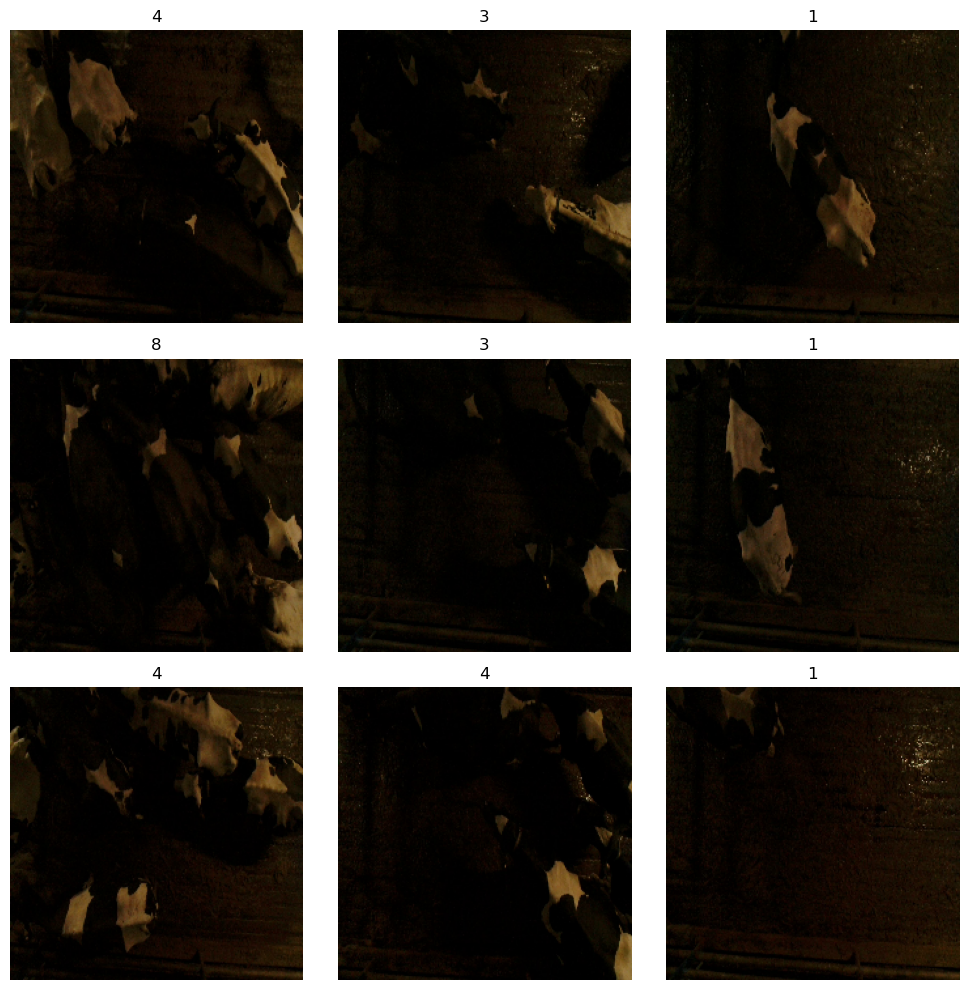

In [65]:
show_batch(train_ds, train_class_names)

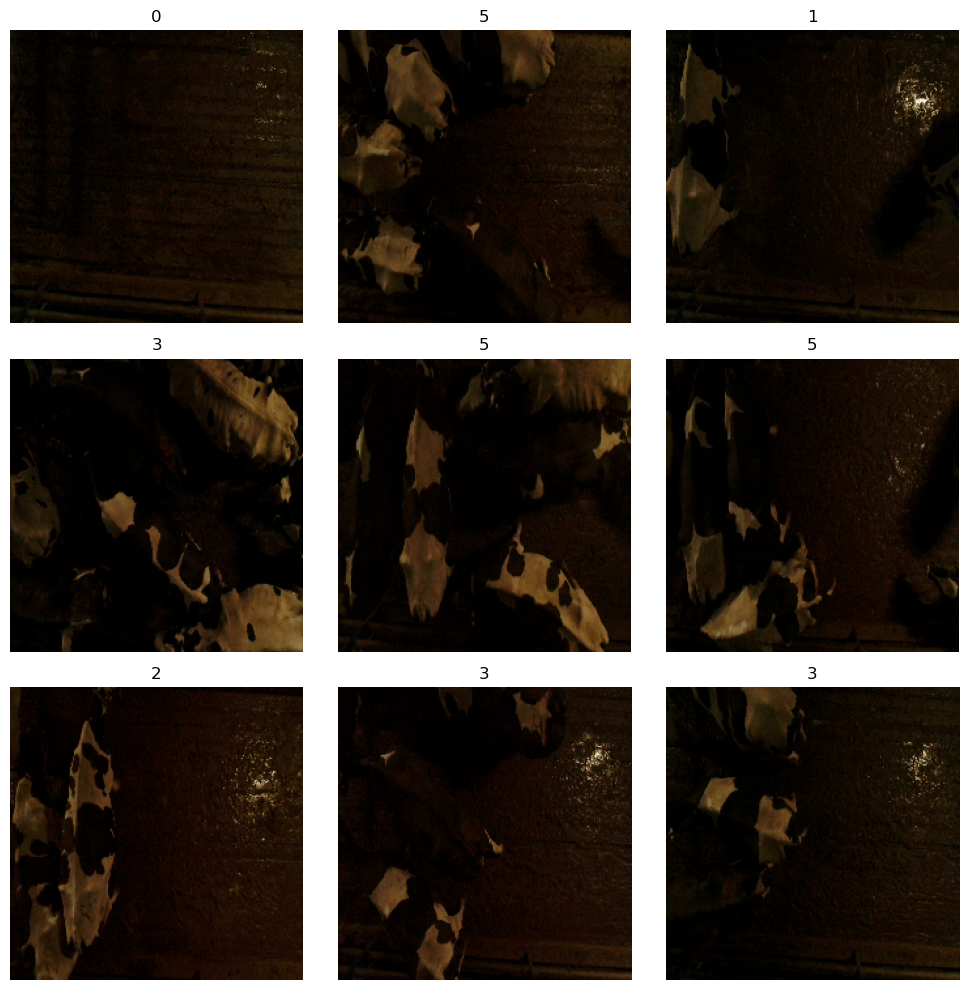

In [66]:
show_batch(val_ds, val_class_names)

Analyzing class distribution: 100%|██████████| 165/165 [00:00<00:00, 180.29it/s]


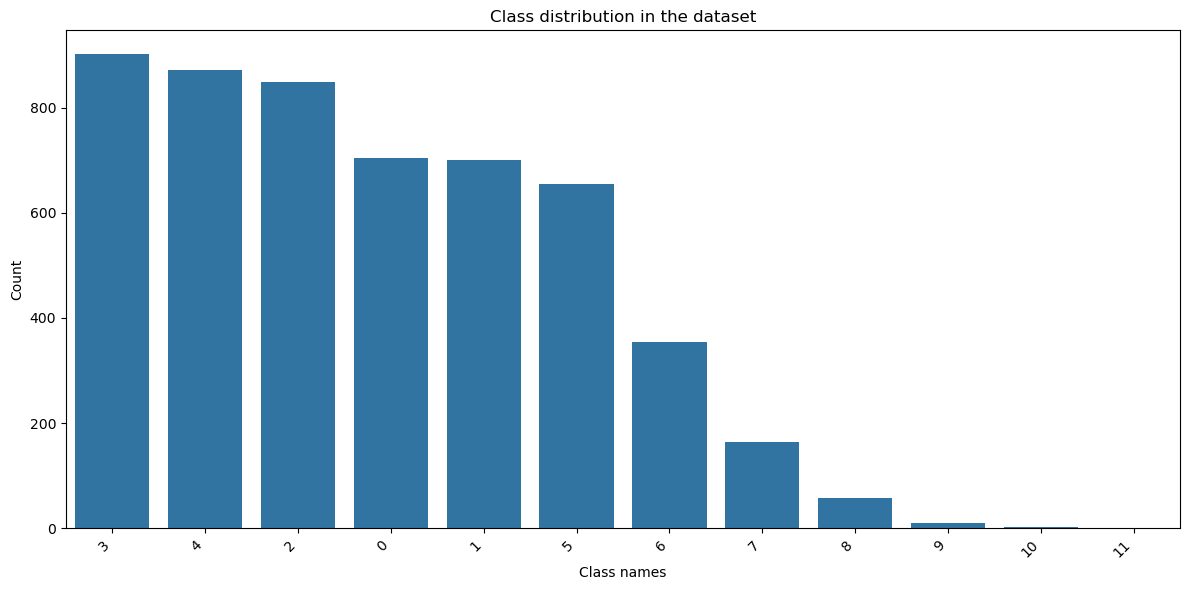

In [67]:
analyze_class_distribution(train_ds, train_class_names)

Analyzing class distribution: 100%|██████████| 40/40 [00:00<00:00, 42.32it/s]


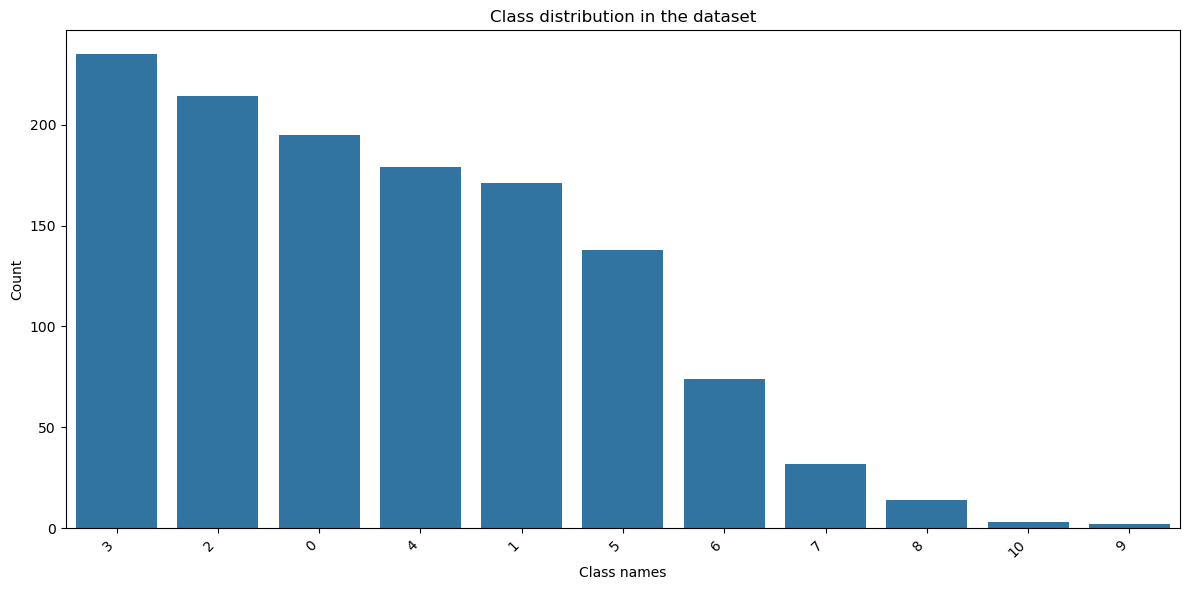

In [68]:
analyze_class_distribution(val_ds, val_class_names)

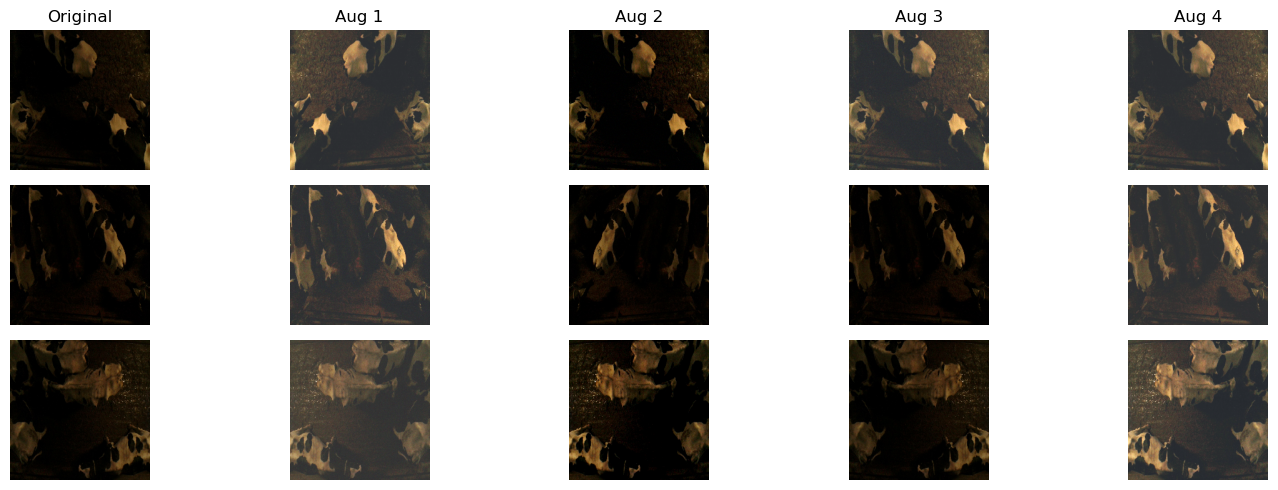

In [69]:
data_augmentation = DataAugmentation(IMG_SIZE)

visualize_data_augmentation(
    dataset=train_ds,
    data_augmentation=data_augmentation,
    num_images=3,
    num_augmentations=4,
)

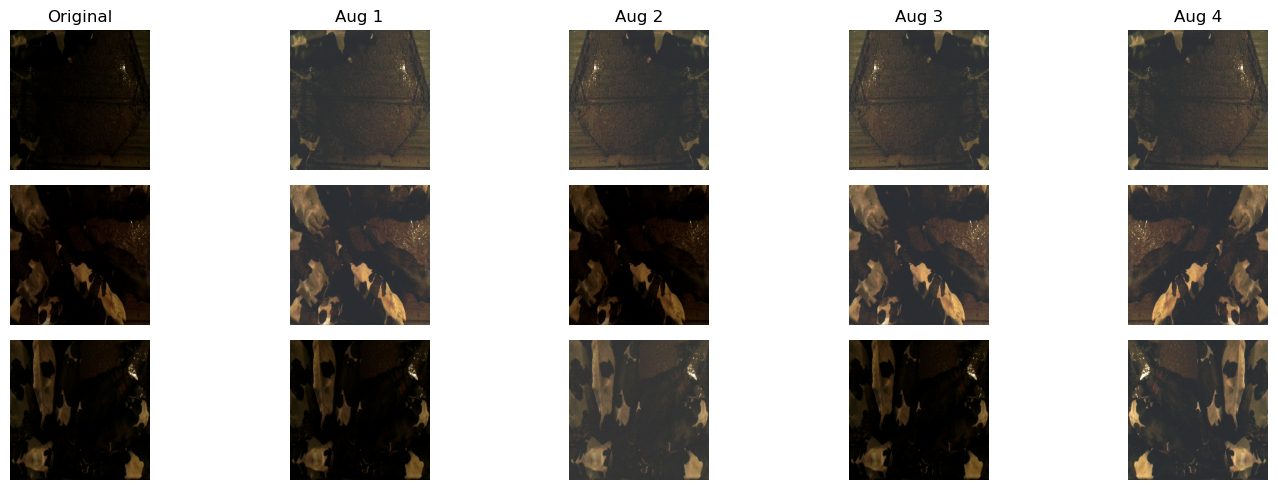

In [70]:
visualize_data_augmentation(
    dataset=val_ds,
    data_augmentation=data_augmentation,
    num_images=3,
    num_augmentations=4,
)

### Creating the base model


In [71]:
config = ModelConfig(
    num_classes=len(train_class_names),
    input_shape=(224, 224, 3),
    learning_rate=5e-4,
    weight_decay=0.01,
    dropout_rate=0.3,
    train_size=len(train_ds) * 32,
    epochs=50,
)

In [72]:
model = create_cow_counting_model(config, strategy)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_3             │ (None, 224, 224, 3)    │             0 │
│ (DataAugmentation)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 224, 224, 3)    │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 7, 7, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │        19,980 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,662,860 (48.30 MB)

 Trainable params: 3,512,588 (13.40 MB)

 Non-trainable params: 9,150,272 (34.91 MB)

In [73]:
callbacks, model_dir = create_callback(
    experiment_name="night_cattle_classification", patience=10
)

In [74]:
with strategy.scope():
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
    )

Epoch 1/30


W0000 00:00:1730825027.841237   36047 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825027.884094   36047 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825027.907185   36047 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825027.931079   36047 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825027.957544   36047 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825028.034831   36047 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825028.072593   36047 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825028.092771   36047 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825028.113699   36047 gp

 28/165 ━━━━━━━━━━━━━━━━━━━━ 33s 242ms/step - accuracy: 0.2127 - loss: 2.2770

W0000 00:00:1730825041.962773   36051 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825041.965755   36051 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825041.968869   36051 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825041.972230   36051 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825041.974455   36051 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825041.976841   36051 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825041.979293   36051 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825041.982260   36051 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825041.985064   36051 gp

 29/165 ━━━━━━━━━━━━━━━━━━━━ 58s 429ms/step - accuracy: 0.2145 - loss: 2.2686

W0000 00:00:1730825047.221535   36045 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825047.222544   36045 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825047.223628   36045 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825047.224741   36045 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825047.225867   36045 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825047.227088   36045 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825047.228252   36045 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825047.229459   36045 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825047.230524   36045 gp

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.2868 - loss: 1.9014

W0000 00:00:1730825083.462547   36044 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825083.473203   36044 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825083.485003   36044 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825083.499172   36044 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825083.573969   36044 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825083.593389   36044 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825083.610182   36044 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825083.632370   36044 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825083.667416   36044 gp


Epoch 1: val_accuracy improved from -inf to 0.25617, saving model to models/night_cattle_classification_20241105-104333/checkpoints/best_model.keras


W0000 00:00:1730825090.957147   36049 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825090.958193   36049 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825090.959212   36049 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825090.960211   36049 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825090.961252   36049 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825090.972593   36049 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825090.974872   36049 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825090.975790   36049 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730825090.976679   36049 gp

165/165 ━━━━━━━━━━━━━━━━━━━━ 81s 378ms/step - accuracy: 0.2869 - loss: 1.9004 - val_accuracy: 0.2562 - val_loss: 2.3242 - learning_rate: 1.0000e-04
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.3620 - loss: 1.5800
Epoch 2: val_accuracy improved from 0.25617 to 0.33492, saving model to models/night_cattle_classification_20241105-104333/checkpoints/best_model.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 54s 325ms/step - accuracy: 0.3620 - loss: 1.5799 - val_accuracy: 0.3349 - val_loss: 2.4983 - learning_rate: 1.0000e-04
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.3884 - loss: 1.5006
Epoch 3: val_accuracy did not improve from 0.33492
165/165 ━━━━━━━━━━━━━━━━━━━━ 53s 319ms/step - accuracy: 0.3884 - loss: 1.5004 - val_accuracy: 0.2991 - val_loss: 3.8947 - learning_rate: 1.0000e-04
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.4087 - loss: 1.4318
Epoch 4: val_accuracy did not improve from 0.33492
165/165 ━━━━━━━━━━━━━━━━━━━━ 53s 320ms


Training Summary:
Best Validation Loss: 2.3242 (Epoch 1)
Best Validation Accuracy: 0.4105
Final Training Accuracy: 0.4981
Final Validation Accuracy: 0.3556
Total Epochs: 30

Overfitting Metrics:
Final Accuracy Difference: 0.1425
Max Accuracy Difference: 0.4193

Plot saved to: models/night_cattle_classification_20241105-104333/checkpoints/training_plot.png


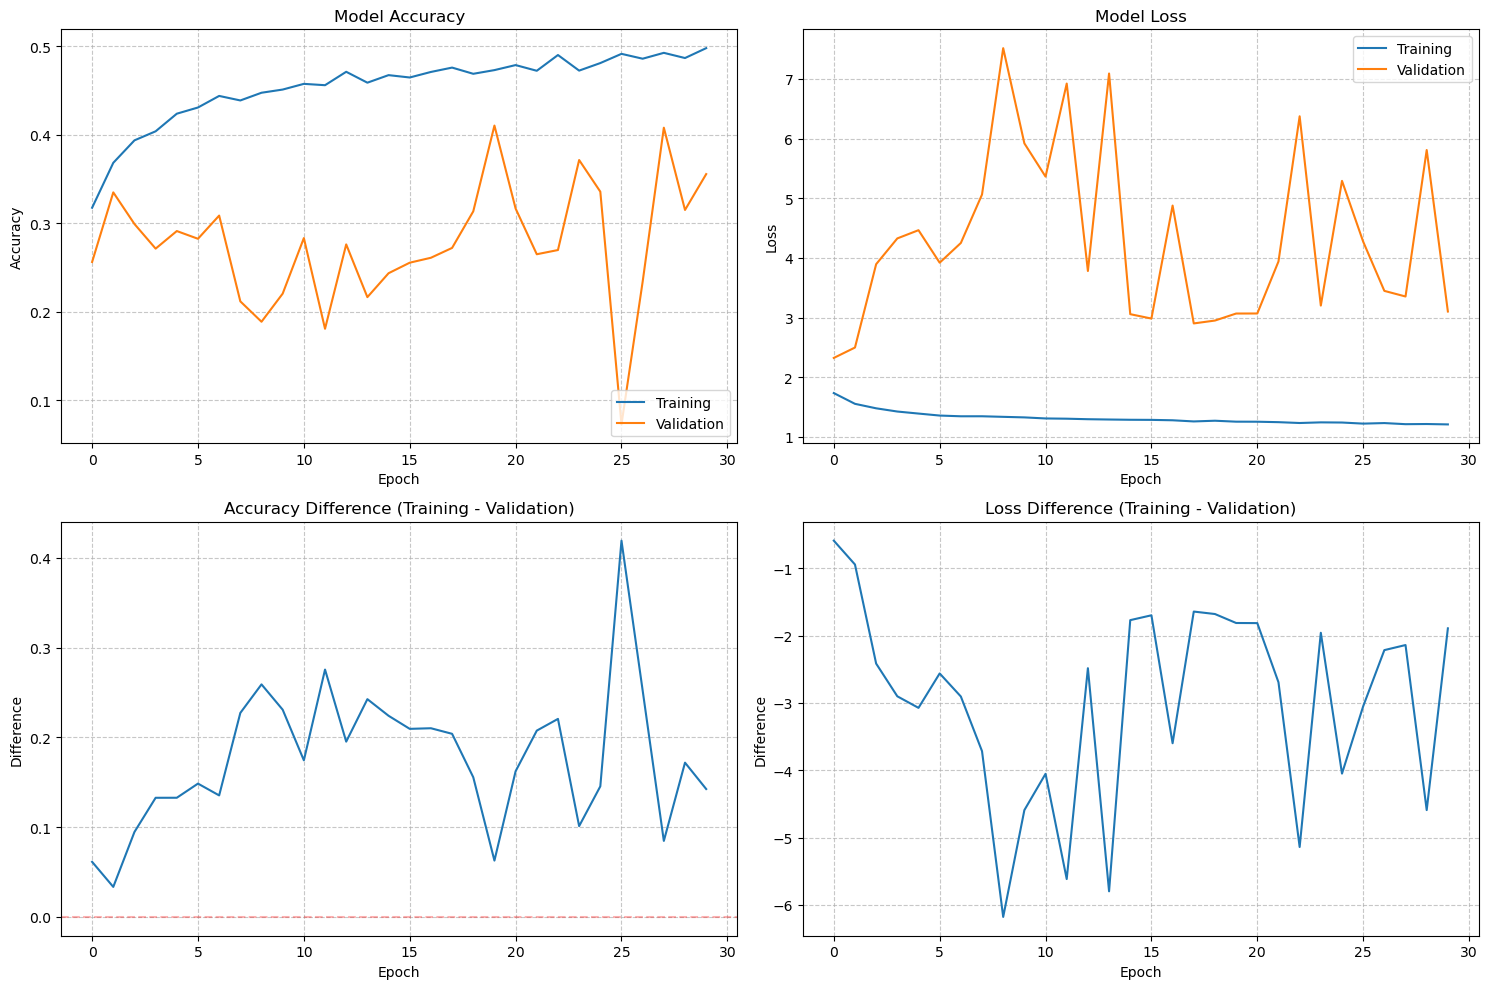

In [75]:
visualize_detailed_history(history, save_path=f"{model_dir}/training_plot.png")

## Prediction


In [76]:
test_base_path = "../data/processed/split/test/night"

In [77]:
test_ds, _, test_class_names, _ = load_dataset(
    test_base_path, val_base_path, IMG_SIZE, BATCH_SIZE
)

Found 722 files belonging to 10 classes.
Found 1257 files belonging to 11 classes.


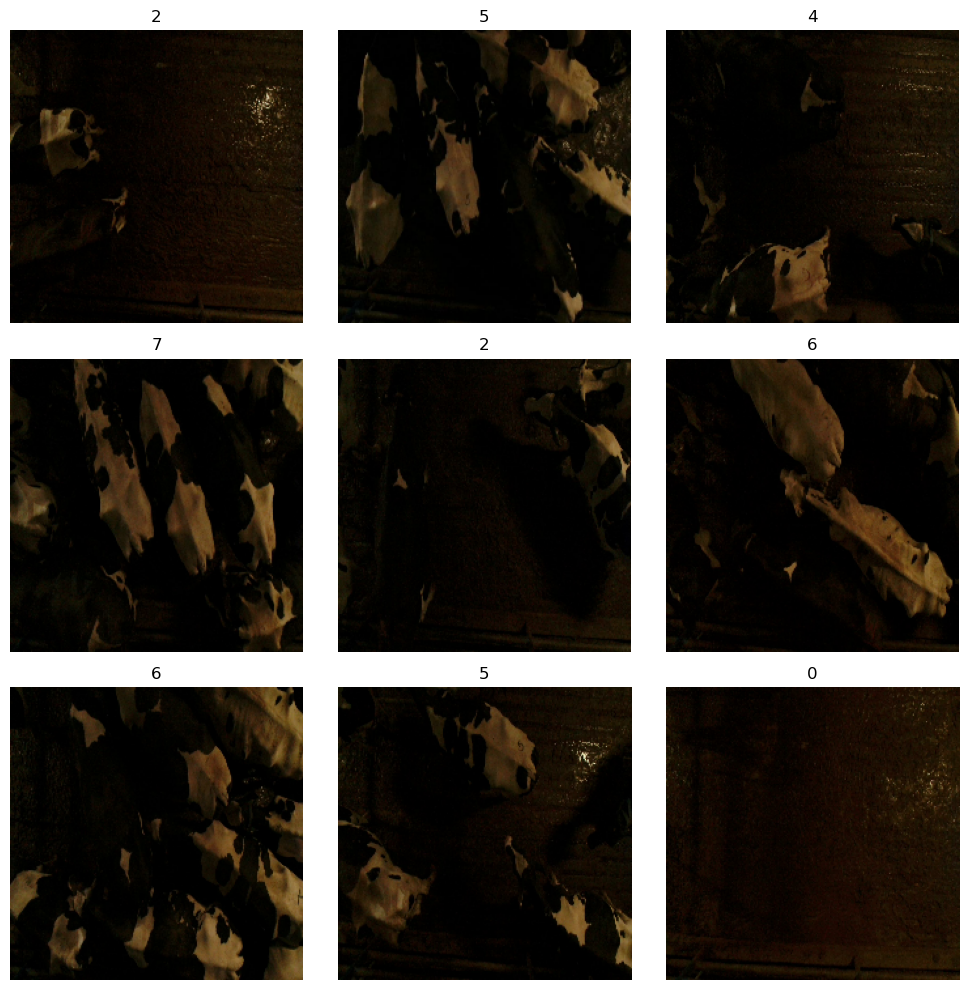

In [78]:
show_batch(test_ds, test_class_names)

In [80]:
model.evaluate(test_ds)

13/23 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.3003 - loss: 4.6001

W0000 00:00:1730826738.175673   36041 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730826738.177228   36041 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730826738.178757   36041 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730826738.180512   36041 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730826738.184802   36041 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730826738.186809   36041 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730826738.188877   36041 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730826738.191277   36041 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730826738.194337   36041 gp

14/23 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.3003 - loss: 4.5857

W0000 00:00:1730826738.377716   36041 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730826738.379988   36041 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730826738.381163   36041 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730826738.398484   36041 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730826738.406934   36041 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730826738.407863   36041 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730826738.408854   36041 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730826738.409765   36041 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730826738.410690   36041 gp

23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.3013 - loss: 4.4860


[4.3542070388793945, 0.3005540072917938]